In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# File paths
border_fp = "/Users/JChong/City-of-Toronto/Data/Helsinki_borders.shp"
grid_fp = "/Users/JChong/City-of-Toronto/Data/TravelTimes_to_5975375_RailwayStation.shp"

# Read files
grid = gpd.read_file(grid_fp)
hel = gpd.read_file(border_fp)

In [18]:
#checking crs of gdf
print(grid.crs,'\n', hel.crs)
hel.head()

{'init': 'epsg:3067'} 
 {'init': 'epsg:3067'}


,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,27517366,Helsinki,Helsingfors,091,"POLYGON ((399936.363 6684600.244, 399937.63 66..."


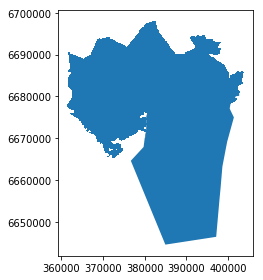

In [11]:
#plot the gdf for visuals

#making the Helsinki border our base map
basemap = hel.plot()

grid.plot(ax=basemap,linewidth = 0.2);
# Use tight layout
plt.tight_layout()

In [12]:
#Let’s do an overlay analysis and select polygons from grid that intersect with our Helsinki layer
result = gpd.overlay(grid, hel, how='intersection')

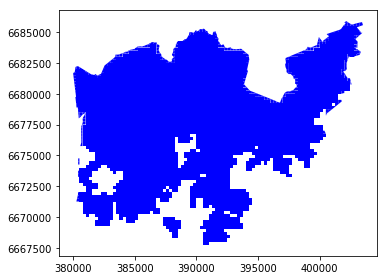

In [14]:
#plot our result
result.plot(color="b")
# Use tight layout
plt.tight_layout()

#Now as a result we have only those grid cells included that intersect with the Helsinki borders 
#and the grid cells are clipped based on the boundary

In [16]:
#we have attributes of both layers included
result.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
94,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.0001322526 6685750.000039577,..."
95,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402367.8898583531 6685750.000039573,..."
96,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000132058 6685750.000039549, ..."
97,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403456.4840652301 6685750.000039542,..."
193,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((402000.0001323065 6685500.000039622,..."


In [19]:
#see the len of result which means how many instances in the gdf
#so there were 3826 polygons or stations intersects the Helsinki border
len(result)

3826

In [21]:
len(grid)

13231

In [23]:
#save the result grid as a GEOJSON file
resultfp = "/Users/JChong/City-of-Toronto/Data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Use GeoJSON driver

result.to_file(resultfp, driver="GeoJSON")

Aggregating Data

In [24]:
#Let’s aggregate our travel time data by car travel times, i.e. the grid cells that have the same travel 
#time to Railway Station will be merged together.

result_aggregated = result.dissolve(by="car_r_t")

In [25]:
#Indeed the number of rows in our data has decreased and the Polygons were merged together
result_aggregated.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,"(POLYGON ((388000.0001354803 6668750.0000429, ...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((386000.0001357812 6672000.000042388,...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386250.0001357396 6671750.000042424,...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,(POLYGON ((386250.0001357467 6671500.000042468...,1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
9,(POLYGON ((387000.0001355996 6671500.000042449...,1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


In [30]:
len(result_aggregated)

51

Data Reclassification

The target in this part of the lesson is to:

1. classify the lakes into big and small lakes where

    a big lake is a lake that is larger than the average size of all lakes in our study region
    a small lake ^ vice versa
    
2. use travel times and distances to find out

    good locations to buy an apartment with good public tranportation accessibility to city center
    but from a bit further away from city center where the prices are lower (or at least we assume so).

3. use ready made classifiers from pysal -module to classify travel times into multiple classes.

In [31]:


# File path
fp2 = "/Users/JChong/City-of-Toronto/Data/Corine2012_Uusimaa.shp"

data = gpd.read_file(fp2)

In [32]:
data.head()

,Level1,Level1Eng,Level1Suo,Level2,Level2Eng,Level2Suo,Level3,Level3Eng,Level3Suo,Luokka3,geometry
0,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((279500 6640640, 279507.469 6640635.3..."
1,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((313620 6655820, 313639.8910000001 66..."
2,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((399720 6680460, 399672.2120000001 66..."
3,3,Forests and semi-natural areas,Metsät sekä avoimet kankaat ja kalliomaat,32,Shrub and/or herbaceous vegetation associations,Harvapuustoiset metsät ja pensastot,324,Transitional woodland/shrub,Harvapuustoiset alueet,324,"POLYGON ((469320 6718500, 469344.023 6718358.6..."
4,3,Forests and semi-natural areas,Metsät sekä avoimet kankaat ja kalliomaat,32,Shrub and/or herbaceous vegetation associations,Harvapuustoiset metsät ja pensastot,324,Transitional woodland/shrub,Harvapuustoiset alueet,324,"POLYGON ((403180 6718140, 403179.318 6718132.3..."


In [36]:
#select only the English columns
select_col = ['Level1','Level1Eng','Level2','Level2Eng','Level3','Level3Eng','Luokka3','geometry']

#select data
data = data[select_col]

#seeing what columns data gdf
data.columns

Index(['Level1', 'Level1Eng', 'Level2', 'Level2Eng', 'Level3', 'Level3Eng',
       'Luokka3', 'geometry'],
      dtype='object')

In [35]:
data.head()

,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry
0,1,Artificial surfaces,11,Urban fabric,112,Discontinuous urban fabric,112,"POLYGON ((279500 6640640, 279507.469 6640635.3..."
1,1,Artificial surfaces,11,Urban fabric,112,Discontinuous urban fabric,112,"POLYGON ((313620 6655820, 313639.8910000001 66..."
2,1,Artificial surfaces,11,Urban fabric,112,Discontinuous urban fabric,112,"POLYGON ((399720 6680460, 399672.2120000001 66..."
3,3,Forests and semi-natural areas,32,Shrub and/or herbaceous vegetation associations,324,Transitional woodland/shrub,324,"POLYGON ((469320 6718500, 469344.023 6718358.6..."
4,3,Forests and semi-natural areas,32,Shrub and/or herbaceous vegetation associations,324,Transitional woodland/shrub,324,"POLYGON ((403180 6718140, 403179.318 6718132.3..."


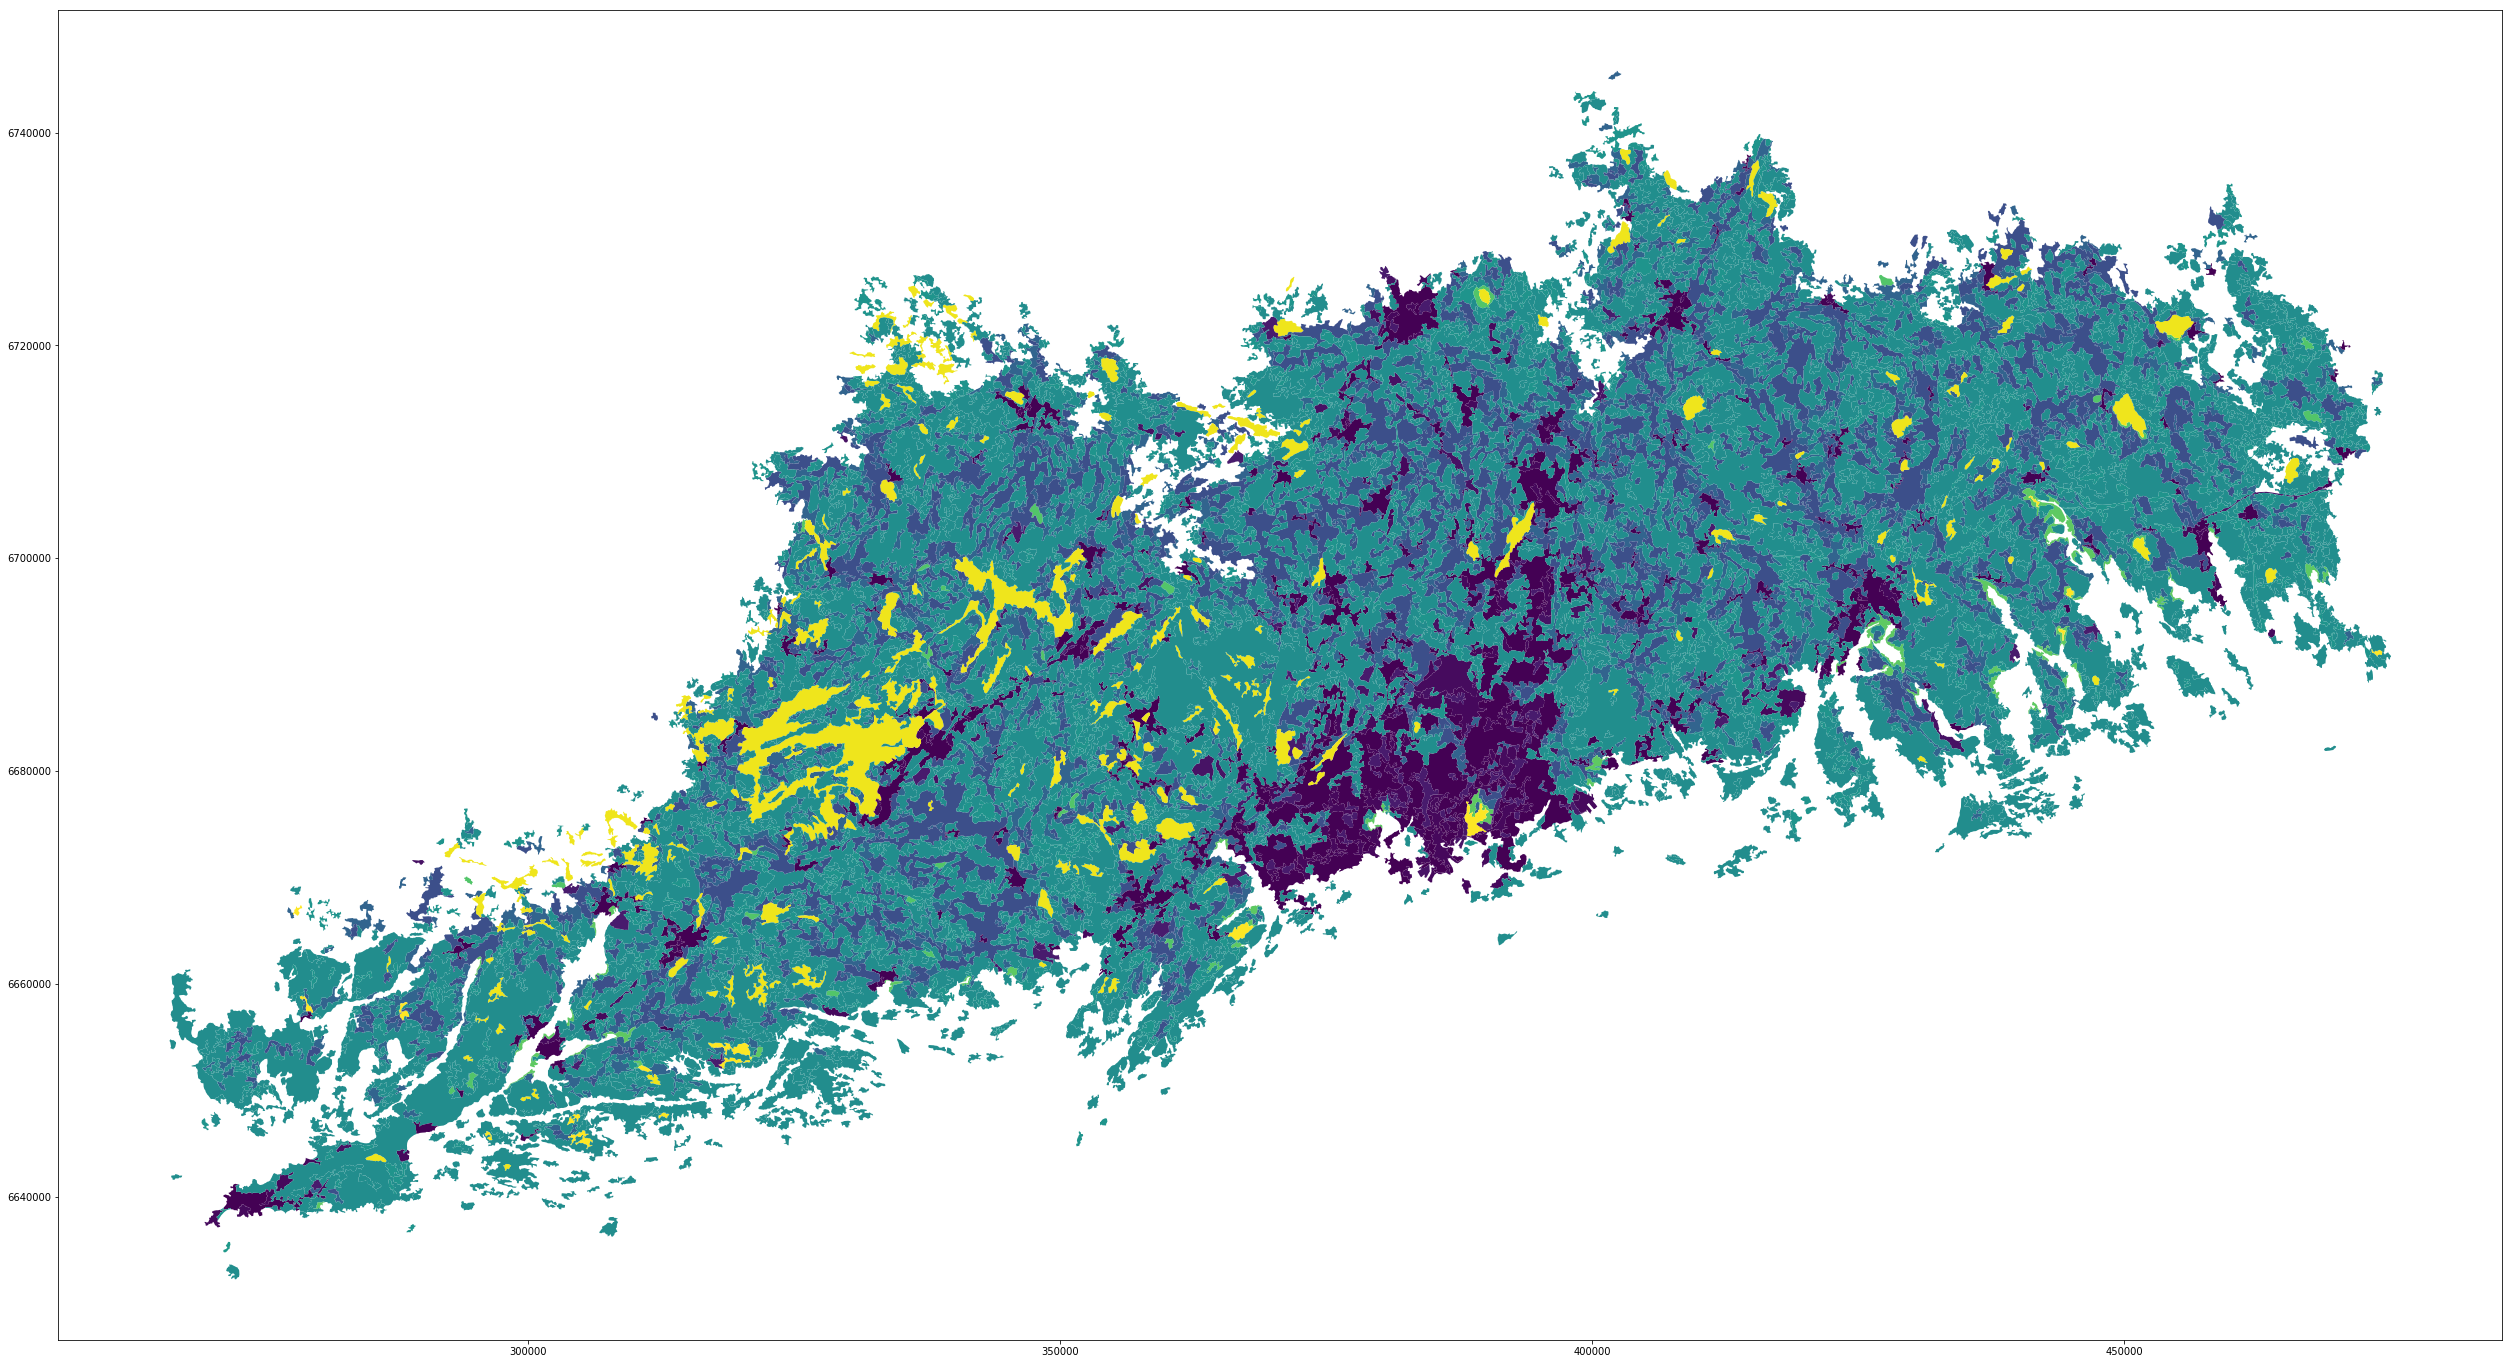

In [38]:
data.plot(column='Level3', linewidth=0.05, figsize=(35,35))

# Use tight layout and remove empty whitespace around our map
plt.tight_layout()

In [39]:
#see the different unique values in level3Eng
list(data['Level3Eng'].unique())

['Discontinuous urban fabric',
 'Transitional woodland/shrub',
 'Non-irrigated arable land',
 'Fruit trees and berry plantations',
 'Pastures',
 'Land principally occupied by agriculture, with significant areas of natural vegetation',
 'Bare rock',
 'Inland marshes',
 'Peatbogs',
 'Salt marshes',
 'Water courses',
 'Water bodies',
 'Sea and ocean',
 'Industrial or commercial units',
 'Road and rail networks and associated land',
 'Port areas',
 'Airports',
 'Mineral extraction sites',
 'Broad-leaved forest',
 'Dump sites',
 'Coniferous forest',
 'Construction sites',
 'Green urban areas',
 'Sport and leisure facilities',
 'Mixed forest']

In [51]:
# Select lakes (i.e. 'waterbodies' in the data) and make a proper copy out of our data
lakes = data.loc[data['Level3Eng'] == 'Water bodies'].copy()
lakes.head(2)

,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry
1388,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((298388.189 6642944.189999999, 298364..."
1389,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((286629.2579999999 6643429.219000001,..."


In [52]:
lakes.crs

{'proj': 'utm', 'zone': 35, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}

In [57]:
#calculate the lake areas
lakes['area']=lakes.area
lakes.head(2)


,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry,area
1388,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((298388.189 6642944.189999999, 298364...",268310.708164
1389,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((286629.2579999999 6643429.219000001,...",917661.921348


In [60]:
#areas are in sq m but let's change it to sq km
lakes['area_km2']=lakes['area']/1000000
lakes.head(2)

,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry,area,area_km2
1388,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((298388.189 6642944.189999999, 298364...",268310.708164,0.268311
1389,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((286629.2579999999 6643429.219000001,...",917661.921348,0.917662


In [63]:
#calculate the mean size of the lakes
l_mean_size = lakes['area_km2'].mean()
l_mean_size

1.5828513727796711